In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model
print(1)

1


In [8]:
df_eng= pd.read_csv('../csv_file_data/french_dataset.csv', encoding='latin-1')
df_eng['Language'] = 'English'

df_spa = pd.read_csv('../csv_file_data/french_dataset.csv', encoding='latin-1')
df_spa['Language'] = 'Spanish'

df = pd.concat([df_eng, df_spa], ignore_index=True)

print(1)

1


In [9]:

# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = ''.join([char for char in text if char.isalnum() or char.isspace()])  # Remove special characters
    else:
        text = str(text)  # Handle NaN values by converting to string
    return text

# Clean the text data
df['Text'] = df['Text'].apply(clean_text)

# Remove rows with empty strings after cleaning
df = df[df['Text'] != '']
print(1)

1


In [10]:
max_num_words = 10000  # Maximum number of words in the tokenizer
max_seq_length = 100  # Maximum sequence length
print(1)

1


In [11]:
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)
print(1)

1


In [12]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['Emotion'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
print(1)

1


In [13]:

# Step 2: Build the RNN model with LSTM units set to 256
model = Sequential()
model.add(Embedding(max_num_words, 128, input_length=max_seq_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))  # Change LSTM units to 256
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Build the model
model.build(input_shape=(None, max_seq_length))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
print(model.summary())
print(1)

C:\Users\umama\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,707,781 (6.51 MB)

 Trainable params: 1,707,781 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

None
1


In [14]:

# Step 3: Train the model
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# Step 4: Evaluate the model
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')
print(1)

Epoch 1/20
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 633s 397ms/step - accuracy: 0.4933 - loss: 1.2658 - val_accuracy: 0.6908 - val_loss: 0.8484 - learning_rate: 0.0010
Epoch 2/20
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 556s 353ms/step - accuracy: 0.7638 - loss: 0.6760 - val_accuracy: 0.7517 - val_loss: 0.7144 - learning_rate: 0.0010
Epoch 3/20
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 592s 372ms/step - accuracy: 0.8316 - loss: 0.4860 - val_accuracy: 0.7894 - val_loss: 0.6425 - learning_rate: 0.0010
Epoch 4/20
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 578s 367ms/step - accuracy: 0.8748 - loss: 0.3707 - val_accuracy: 0.8155 - val_loss: 0.5971 - learning_rate: 0.0010
Epoch 5/20
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 594s 377ms/step - accuracy: 0.9060 - loss: 0.2802 - val_accuracy: 0.8372 - val_loss: 0.5706 - learning_rate: 0.0010
Epoch 6/20
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 595s 377ms/step - accuracy: 0.9232 - loss: 0.2261 - val_accuracy: 0.8480 - val_loss: 0.5880 - learning_rate: 0.0010
Epoch 7/20
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 588s 373ms

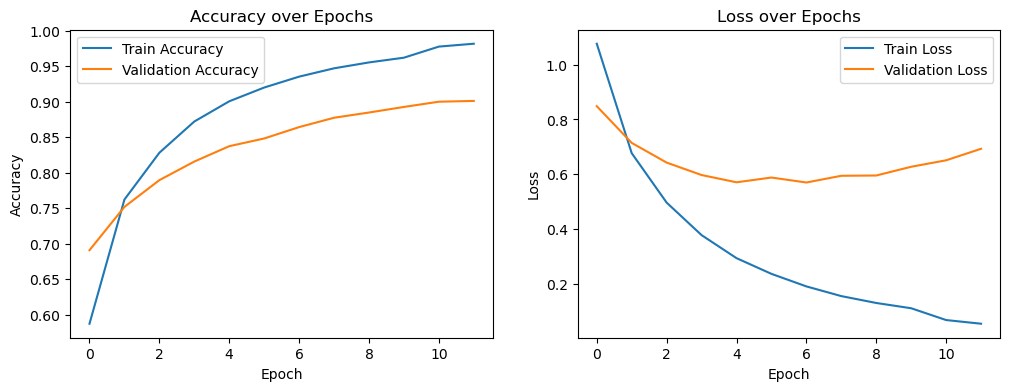

395/395 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step
              precision    recall  f1-score   support

     colÃ¨re       0.83      0.87      0.85      1697
        joie       0.88      0.89      0.88      4401
        peur       0.93      0.88      0.90      2180
  surprendre       0.79      0.81      0.80      1636
   tristesse       0.85      0.85      0.85      2701

    accuracy                           0.86     12615
   macro avg       0.86      0.86      0.86     12615
weighted avg       0.87      0.86      0.86     12615



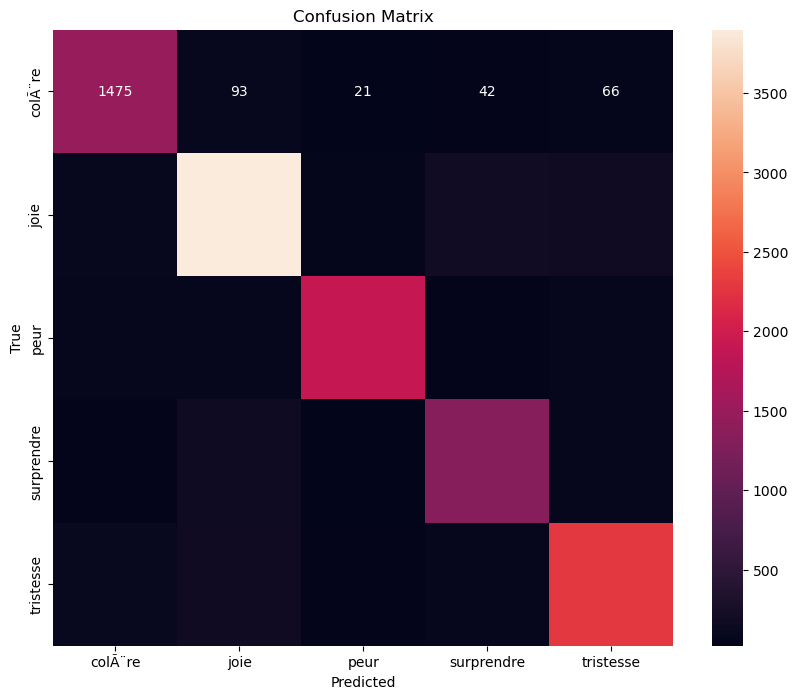

In [15]:

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Generate classification report
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=-1)
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Step 5: Save the model
model.save('french.h5')


In [32]:
# Load the saved model
saved_model = load_model('french.h5')

example_text_eng = "Elle tremblait de tout son corps."


# Clean and tokenize the English text
cleaned_text_eng = clean_text(example_text_eng)
tokenized_text_eng = tokenizer.texts_to_sequences([cleaned_text_eng])
padded_text_eng = pad_sequences(tokenized_text_eng, maxlen=max_seq_length)

# Predict the emotion for English text
prediction_eng = saved_model.predict(padded_text_eng)
predicted_class_eng = prediction_eng.argmax(axis=-1)[0]
predicted_emotion_eng = label_encoder.inverse_transform([predicted_class_eng])[0]

print(f'Example Text (English): {example_text_eng}')
print(f'Predicted Emotion (English): {predicted_emotion_eng}')

# Example text for prediction (Spanish)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
Example Text (English): Elle tremblait de tout son corps.
Predicted Emotion (English): colÃ¨re
